In [1]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes trl fsspec -U  -qq ## NEW LINES ##
  !pip install transformers evaluate wandb datasets accelerate -U peft bitsandbytes -qq

  basepath = '/content/drive/MyDrive/NLP UTD/'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
ERROR: pip

In [2]:
# standard pythgion libraries
from pathlib import Path
import re
import gc
import time
from typing import Dict, List, Union, Optional
from tqdm import tqdm
import itertools
import json
import joblib
import ast
from datetime import datetime
from difflib import get_close_matches

# Data Science librraies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

# Pytorch
import torch
import torch.nn as nn

# Huggingface Librraies
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
    AutoPeftModelForCausalLM,
    PeftConfig
)

from huggingface_hub import login

# Logging and secrets
import wandb
from google.colab import userdata

In [3]:
set_seed(42)

In [4]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')


In [5]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


Successfully logged in to Hugging Face!


In [6]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mowvagangagovardhan14 (mowvagangagovardhan14-the-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [7]:
# Set the base folder path using the Path class for better path handling
base_folder = Path(basepath)

# Define the data folder path by appending the relative path to the base folder
# This is where the data files will be stored
data_folder = base_folder / 'datasets'

# Define the model folder path for saving trained models
# This path points to a specific folder designated for NLP models related to the IMDb dataset
model_folder = base_folder / 'models'

custom_functions = base_folder/'custom-functions'


In [8]:
train_data=pd.read_csv(data_folder/'train.csv')


In [9]:
train_data.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [10]:
# List of emotion columns
emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love",
                   "optimism", "pessimism", "sadness", "surprise", "trust"]

# Create a new column with the names of emotions where the value is 1
train_data["emotions"] = train_data[emotions].apply(
    lambda row: " ".join([emotion for emotion in emotions if row[emotion] == 1]), axis=1
)

# Display the DataFrame
print(train_data)

              ID                                              Tweet  anger  \
0     2017-21441  “Worry is a down payment on a problem you may ...      0   
1     2017-31535  Whatever you decide to do make sure it makes y...      0   
2     2017-21068  @Max_Kellerman  it also helps that the majorit...      1   
3     2017-31436  Accept the challenges so that you can literall...      0   
4     2017-22195  My roommate: it's okay that we can't spell bec...      1   
...          ...                                                ...    ...   
7719  2018-01993  @BadHombreNPS @SecretaryPerry If this didn't m...      1   
7720  2018-01784  Excited to watch #stateoforigin tonight! Come ...      0   
7721  2018-04047  Blah blah blah Kyrie, IT, etc. @CJC9BOSS leavi...      1   
7722  2018-03041  #ThingsIveLearned The wise #shepherd never tru...      0   
7723  2018-03386  I am really flattered and happy to hear those ...      0   

      anticipation  disgust  fear  joy  love  optimism  pessimi

In [11]:
stack= Dataset.from_pandas(train_data)

In [12]:
selected_columns = {
    'text': stack['Tweet'],
    'tag': stack['emotions']
}

# Create a new dataset with the selected columns
stack_columns = Dataset.from_dict(selected_columns)

In [13]:
stack_columns

Dataset({
    features: ['text', 'tag'],
    num_rows: 7724
})

In [14]:
stack_columns['tag'][0]

'anticipation optimism trust'

In [15]:
# Set the format to Pandas
stack_columns.set_format(type='pandas')

In [16]:
df = stack_columns[:]

In [17]:
# Remove existing quotes first (if any) and then add just one set
import json
df['label'] = df['tag'].str.split().apply(lambda x: json.dumps([tag.strip() for tag in x]))


In [18]:
df_final = df[['text', 'label']]

In [19]:
df_final

,text,label
0,“Worry is a down payment on a problem you may ...,"[""anticipation"", ""optimism"", ""trust""]"
1,Whatever you decide to do make sure it makes y...,"[""joy"", ""love"", ""optimism""]"
2,@Max_Kellerman it also helps that the majorit...,"[""anger"", ""disgust"", ""joy"", ""optimism""]"
3,Accept the challenges so that you can literall...,"[""joy"", ""optimism""]"
4,My roommate: it's okay that we can't spell bec...,"[""anger"", ""disgust""]"
...,...,...
7719,@BadHombreNPS @SecretaryPerry If this didn't m...,"[""anger"", ""disgust""]"
7720,Excited to watch #stateoforigin tonight! Come ...,"[""joy"", ""optimism""]"
7721,"Blah blah blah Kyrie, IT, etc. @CJC9BOSS leavi...","[""anger"", ""disgust"", ""sadness""]"
7722,#ThingsIveLearned The wise #shepherd never tru...,[]


In [20]:
class_names = ["anger", "anticipation", "disgust", "fear", "joy", "love",
                   "optimism", "pessimism", "sadness", "surprise", "trust"]

In [21]:
stack_selected_columns_final = Dataset.from_pandas(df_final)

In [22]:
stack_selected_columns_final[0]['label']

'["anticipation", "optimism", "trust"]'

In [23]:
# Split the test set into test and validation sets
train_valid_splits_data = stack_selected_columns_final.train_test_split(test_size=0.2, seed=42)
train_data= train_valid_splits_data['train']
val_data = train_valid_splits_data['test']

In [24]:
train_val_subset= DatasetDict(
    {"train": train_data, "valid": val_data})

In [25]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1545
    })
})

In [26]:
train_val_subset['train'][0]

{'text': 'Does anyone know, are both Sims in a dual sim phone both locked to the same network! #worry',
 'label': '["fear", "pessimism", "sadness"]'}

In [27]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [28]:
free_gpu_memory()

GPU memory has been freed.


In [29]:
checkpoint = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [30]:
tokenizer.eos_token


'<|eot_id|>'

In [31]:
tokenizer.pad_token

In [32]:
tokenizer.pad_token = '<|finetune_right_pad_id|>'

In [33]:
tokenizer.padding_side

'right'

In [34]:
tokenizer.chat_template

'{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- if strftime_now is defined %}\n        {%- set date_string = strftime_now("%d %b %Y") %}\n    {%- else %}\n        {%- set date_string = "26 Jul 2024" %}\n    {%- endif %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0][\'role\'] == \'system\' %}\n    {%- set system_message = messages[0][\'content\']|trim %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = "" %}\n{%- endif %}\n\n{#- System message #}\n{{- "<|start_header_id|>system<|end_header_id|>\\n\\n" }}\n{%- if tools is not none %}\n    {{- "Environment: ipython\\n" }}\n{%- endif %}\n{{- "Cutting

In [35]:
def format_chat(example):
    instruction = f"Classify the TEXT by selecting all applicable labels from the following list: {class_names}.\n\nTEXT: {example['text']}"
    messages = [
        {"role": "user", "content": instruction},
        {"role": "assistant", "content": f"{example['label']}"}
    ]
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False)}


In [36]:
train_val_subset_chat = train_val_subset.map(format_chat)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [37]:
train_val_subset_chat

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1545
    })
})

In [ ]:
train_val_subset_chat['train'][0]

In [38]:
def check_length(example):
   encoding = tokenizer.encode(example['text'])
   return len(encoding) <= 1000

train_filtered = train_val_subset_chat['train'].filter(check_length)
valid_filtered = train_val_subset_chat['valid'].filter(check_length)

print(f"Train: {len(train_val_subset_chat['train'])} -> {len(train_filtered)}")
print(f"Valid: {len(train_val_subset_chat['valid'])} -> {len(valid_filtered)}")

Filter:   0%|          | 0/6179 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1545 [00:00<?, ? examples/s]

Train: 6179 -> 6179
Valid: 1545 -> 1545


In [39]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [40]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [41]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [42]:
model = AutoModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,)


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [43]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-0

In [44]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [45]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'lm_head']


['o_proj',
 'v_proj',
 'up_proj',
 'gate_proj',
 'down_proj',
 'lm_head',
 'k_proj',
 'q_proj']

In [46]:
TaskType.CAUSAL_LM

<TaskType.CAUSAL_LM: 'CAUSAL_LM'>

In [47]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
lora_model.print_trainable_parameters()

trainable params: 90,177,536 || all params: 1,325,991,936 || trainable%: 6.8008


In [48]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder/'models/llama_qlora_lmh_inst'
# model_folder = Path('/content/results')

# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'stack_exp_lmh_gemma_inst'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = SFTConfig(
    max_seq_length= 1024,
    seed = 42,
    dataset_text_field="text",

    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=4,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [49]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    model.config.use_cache = False  # Disable caching for compatibility

model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.

In [50]:
data_collator_comp = DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, mlm=False,
                                                      response_template="assistant<|end_header_id|>")
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_filtered,
    eval_dataset=valid_filtered,

    peft_config=peft_config,
    packing=False,
    data_collator=data_collator_comp,

)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [51]:
%env WANDB_PROJECT = HW8

env: WANDB_PROJECT=HW8


In [52]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


Step,Training Loss,Validation Loss
20,4.736500,0.359734
40,2.867600,0.343957
60,2.575800,0.328947
80,2.480600,0.319573
100,2.467300,0.305002
120,2.530100,0.307620
140,2.567600,0.301668
160,2.410500,0.297930
180,2.435700,0.297109
200,2.322900,0.295662


In [53]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]

In [54]:
best_model_checkpoint_step

'380'

In [55]:
model_folder = base_folder/'models/llama_qlora_lmh_inst'
best_model_checkpoint_step = 380
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint


'/content/drive/MyDrive/NLP UTD/models/llama_qlora_lmh_inst/checkpoint-380'

In [56]:
free_gpu_memory()
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')
model.device
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = '<|finetune_right_pad_id|>'
tokenizer.padding_side = 'left'

GPU memory has been freed.


In [57]:
def format_chat_inference(example):
    instruction = f"Classify the TEXT by selecting all applicable labels from the following list: {class_names}.\n\nTEXT: {example['text']}"
    messages = [
        {"role": "user", "content": instruction},
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return {"text": text}

In [58]:
valid_subset= train_val_subset['valid'].map(format_chat_inference)

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [59]:
valid_filtered['text'][0]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 14 Dec 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nClassify the TEXT by selecting all applicable labels from the following list: [\'anger\', \'anticipation\', \'disgust\', \'fear\', \'joy\', \'love\', \'optimism\', \'pessimism\', \'sadness\', \'surprise\', \'trust\'].\n\nTEXT: @WellerMonica Hi Monica, I write regularly for @ctysmallholding  - but not on bees - never dared try them #buzz  #HONEY<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n["joy"]<|eot_id|>'

In [60]:
valid_filtered[0]['label']

'["joy"]'

In [61]:
def run_inference_instruction(
    seed: int,
    dataset: Union[Dict, List],
    model,
    tokenizer,
    per_device_batch_size: int,
    input_field: str,
    output_field: str,
    save_dir: Optional[Path] = None,
    save_file_name: Optional[str] = None,
    max_new_tokens: int = 20,
    num_beams: int = 1,
    do_sample: bool = False,
    top_k: int = 50,
    top_p: float = 1.0,
    temperature: float = 1.0,
    no_repeat_ngram_size: int = 2,
    num_return_sequences: int = 1
) -> List[Dict]:

    """
    Run inference on a dataset and return complete generations.

    Args:
        seed: Random seed for reproducibility
        dataset: Input dataset (dict or list)
        model: The model to use for inference
        tokenizer: The tokenizer to use
        per_device_batch_size: Batch size for inference
        prompt_template: Template for formatting prompts
        input_field: Field name for input text in dataset
        output_delimiter: Delimiter used in prompt template
        save_path: Optional path to save generations
        ... (generation parameters)

    Returns:
        List of dictionaries containing input, complete generation, and labels
    """

    set_seed(seed)
    model.eval()
    device = model.device
    batch_size = per_device_batch_size
    inference_results = []


    progress_bar = tqdm(range(0, len(dataset), batch_size), desc="Generating predictions")

    for i in progress_bar:
       batch = dataset[i:i + batch_size]

       try:
           texts = batch[input_field]
           labels = batch[output_field] if output_field in batch else ["N/A"] * len(texts)


           inputs = tokenizer(texts, return_tensors="pt", padding=True)
           inputs = {k: v.to(device) for k, v in inputs.items()}

           with torch.no_grad():
               outputs = model.generate(
                   **inputs,
                   max_new_tokens=max_new_tokens,
                   num_beams=num_beams,
                   do_sample=do_sample,
                   top_k=top_k,
                   top_p=top_p,
                   temperature=temperature,
                   pad_token_id=tokenizer.pad_token_id,
               )

           decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=False)

           for text, label, decoded_output in zip(texts, labels, decoded_outputs):
                   inference_results.append({
                    "input": text,
                    "generated_output": decoded_output,
                    "ground_truth": label
                })


       except Exception as e:
           print(f"Error processing batch: {str(e)}")
           continue
    # Save generations if path provided
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        # If no filename provided, create a timestamped one
        if save_file_name is None:
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_name = f"generations_{timestamp}.json"
        elif not save_file_name.endswith('.json'):
            save_name = f"{save_file_name}.json"

        save_file = save_dir / save_name

        with open(save_file, 'w') as f:
            json.dump(inference_results, f, indent=2)
        print(f"Saved inference_results to: {save_file}")

    return inference_results

In [62]:
free_gpu_memory()


GPU memory has been freed.


In [63]:
valid_inference_results = run_inference_instruction(seed = 42,
              dataset=valid_filtered,
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=50,
              input_field='text',
              output_field='label',
              save_dir=model_folder,
              save_file_name = 'valid_complete_generations')

Generating predictions: 100%|██████████| 31/31 [00:49<00:00,  1.61s/it]

Saved inference_results to: /content/drive/MyDrive/NLP UTD/models/llama_qlora_lmh_inst/valid_complete_generations.json


In [64]:
file_name = model_folder/'valid_complete_generations.json'
with open(file_name, 'r') as f:
    valid_inference_results = json.load(f)

In [65]:
valid_inference_results[1]['generated_output']

'<|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|finetune_right_pad_id|><|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday

In [66]:
output_delimiter = "assistant<|end_header_id|>"
def extract_content(generated_output: str, output_delimiter: str) -> str:
    """
    Extract content after delimiter from a generated output string.

    Args:
        generated_output: String containing the complete model generation
        output_delimiter: Delimiter to extract content after

    Returns:
        Extracted content as string, or None if delimiter not found
    """
    pattern = f'{re.escape(output_delimiter.strip())}\\s*(.*?)(?:<\\|eot_id\\|>)'
    match = re.search(pattern, generated_output, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return None


In [67]:
valid_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in valid_inference_results]

In [68]:
valid_extracted_outputs[0]

'["joy"]'

In [69]:
for i in range(20):
  print(valid_extracted_outputs[i])

["joy"]
[]
["anger", "anticipation", "disgust", "optimism"]
["joy", "optimism"]
["anticipation", "pessimism", "sadness"]
["joy", "optimism"]
["anger", "fear"]
["fear", "joy", "optimism"]
["anger", "disgust"]
["anger", "disgust"]
["anger", "disgust"]
["joy", "optimism"]
["anticipation", "joy", "optimism", "sadness"]
[]
["anticipation", "disgust", "joy", "optimism", "sadness"]
["joy", "love"]
["anger", "sadness"]
["anger", "disgust", "fear"]
["anger", "disgust"]
["anger", "disgust", "sadness"]


In [70]:
for i in range(20):
  print(valid_inference_results[i]['ground_truth'])

["joy"]
[]
["anger", "anticipation", "disgust", "optimism"]
["joy", "optimism"]
["anticipation", "pessimism", "sadness"]
["joy", "optimism"]
["anger", "fear"]
["fear", "joy", "optimism"]
["anger", "disgust"]
["anger", "disgust"]
["anger", "disgust"]
["joy", "optimism"]
["anticipation", "joy", "optimism", "sadness"]
[]
["anticipation", "disgust", "joy", "optimism", "sadness"]
["joy", "love"]
["anger", "sadness"]
["anger", "disgust", "fear"]
["anger", "disgust"]
["anger", "disgust", "sadness"]


In [71]:
def clean_and_split_labels(extracted_output: str, class_names: List[str], cutoff: float = 0.6) -> List[str]:
    """
    Clean and normalize extracted content for multi-label classification.

    Args:
        extracted_output: String containing extracted labels
        class_names: List of valid class names
        cutoff: Threshold for fuzzy matching

    Returns:
        List of cleaned and normalized labels
    """
    from difflib import get_close_matches

    # Convert to string if not already
    if isinstance(extracted_output, (list, tuple)):
        label_set = ' '.join(str(x) for x in extracted_output)
    else:
        label_set = str(extracted_output)

    # Basic cleaning
    label_set = label_set.lstrip('=')
    # Remove various bracket and quote combinations
    label_set = label_set.replace('=["', '').replace('["', '').replace('"]', '')
    label_set = label_set.replace("['", '').replace("']", '')
    label_set = label_set.replace('("', '').replace('")', '')
    label_set = label_set.replace('(["', '').replace('"])', '')
    label_set = label_set.replace('([', '').replace('])', '')
    label_set = label_set.replace('[', '').replace(']', '')
    label_set = label_set.replace('(', '').replace(')', '')
    label_set = label_set.replace('"', '').replace("'", '')

    # Handle multiple types of separators
    label_set = ' '.join(label_set.split())  # normalize spaces
    raw_labels = label_set.split(',') if ',' in label_set else label_set.split()

    # Clean and normalize labels
    raw_labels = [label.strip().lower() for label in raw_labels if label.strip()]

    # Match to valid classes using fuzzy matching
    cleaned_labels = []
    for label in raw_labels:
        if label in class_names:
            cleaned_labels.append(label)
        else:
            matches = get_close_matches(label, class_names, n=1, cutoff=cutoff)
            if matches:
                cleaned_labels.append(matches[0])

    # Remove duplicates while preserving order
    seen = set()
    cleaned_labels = [x for x in cleaned_labels if not (x in seen or seen.add(x))]

    return cleaned_labels

In [72]:
# Clean and convert predictions and ground truth
valid_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in valid_extracted_outputs
]

valid_labels = [
    clean_and_split_labels(result['ground_truth'], class_names)
    for result in valid_inference_results
]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
valid_labels_binary = mlb.transform(valid_labels)
valid_predictions_binary = mlb.transform(valid_predictions)

# Print samples and shapes
print("Sample of true labels:", valid_labels[:5])
print("Sample of predictions:", valid_predictions[:5])
print("\nBinary format:")
print("Labels shape:", valid_labels_binary.shape)
print("Predictions shape:", valid_predictions_binary.shape)

Sample of true labels: [['joy'], [], ['anger', 'anticipation', 'disgust', 'optimism'], ['joy', 'optimism'], ['anticipation', 'pessimism', 'sadness']]
Sample of predictions: [['joy'], [], ['anger', 'anticipation', 'disgust', 'optimism'], ['joy', 'optimism'], ['anticipation', 'pessimism', 'sadness']]

Binary format:
Labels shape: (1545, 11)
Predictions shape: (1545, 11)


In [73]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics( labels, preds):
  accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
  accuracy_all = accuracy.compute(predictions=preds, references=labels)
  f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
  f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
  return {'f1_micro':f1_micro['f1'],
          'f1_macro':f1_macro['f1'],
          'accuracy_label':accuracy_label['accuracy'],
            'accuracy_all':accuracy_all['accuracy']}

In [74]:
valid_metrics = compute_metrics(valid_labels_binary , valid_predictions_binary)

In [75]:
valid_metrics

{'f1_micro': 1.0, 'f1_macro': 1.0, 'accuracy_label': 1.0, 'accuracy_all': 1.0}

In [76]:
wandb.log({"valid_f1_macro": valid_metrics["f1_macro"]})

In [77]:
mcm = multilabel_confusion_matrix(valid_labels_binary , valid_predictions_binary)
print(mcm)

[[[ 992    0]
  [   0  553]]

 [[1334    0]
  [   0  211]]

 [[ 954    0]
  [   0  591]]

 [[1266    0]
  [   0  279]]

 [[ 961    0]
  [   0  584]]

 [[1369    0]
  [   0  176]]

 [[1072    0]
  [   0  473]]

 [[1364    0]
  [   0  181]]

 [[1122    0]
  [   0  423]]

 [[1463    0]
  [   0   82]]

 [[1451    0]
  [   0   94]]]


In [78]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


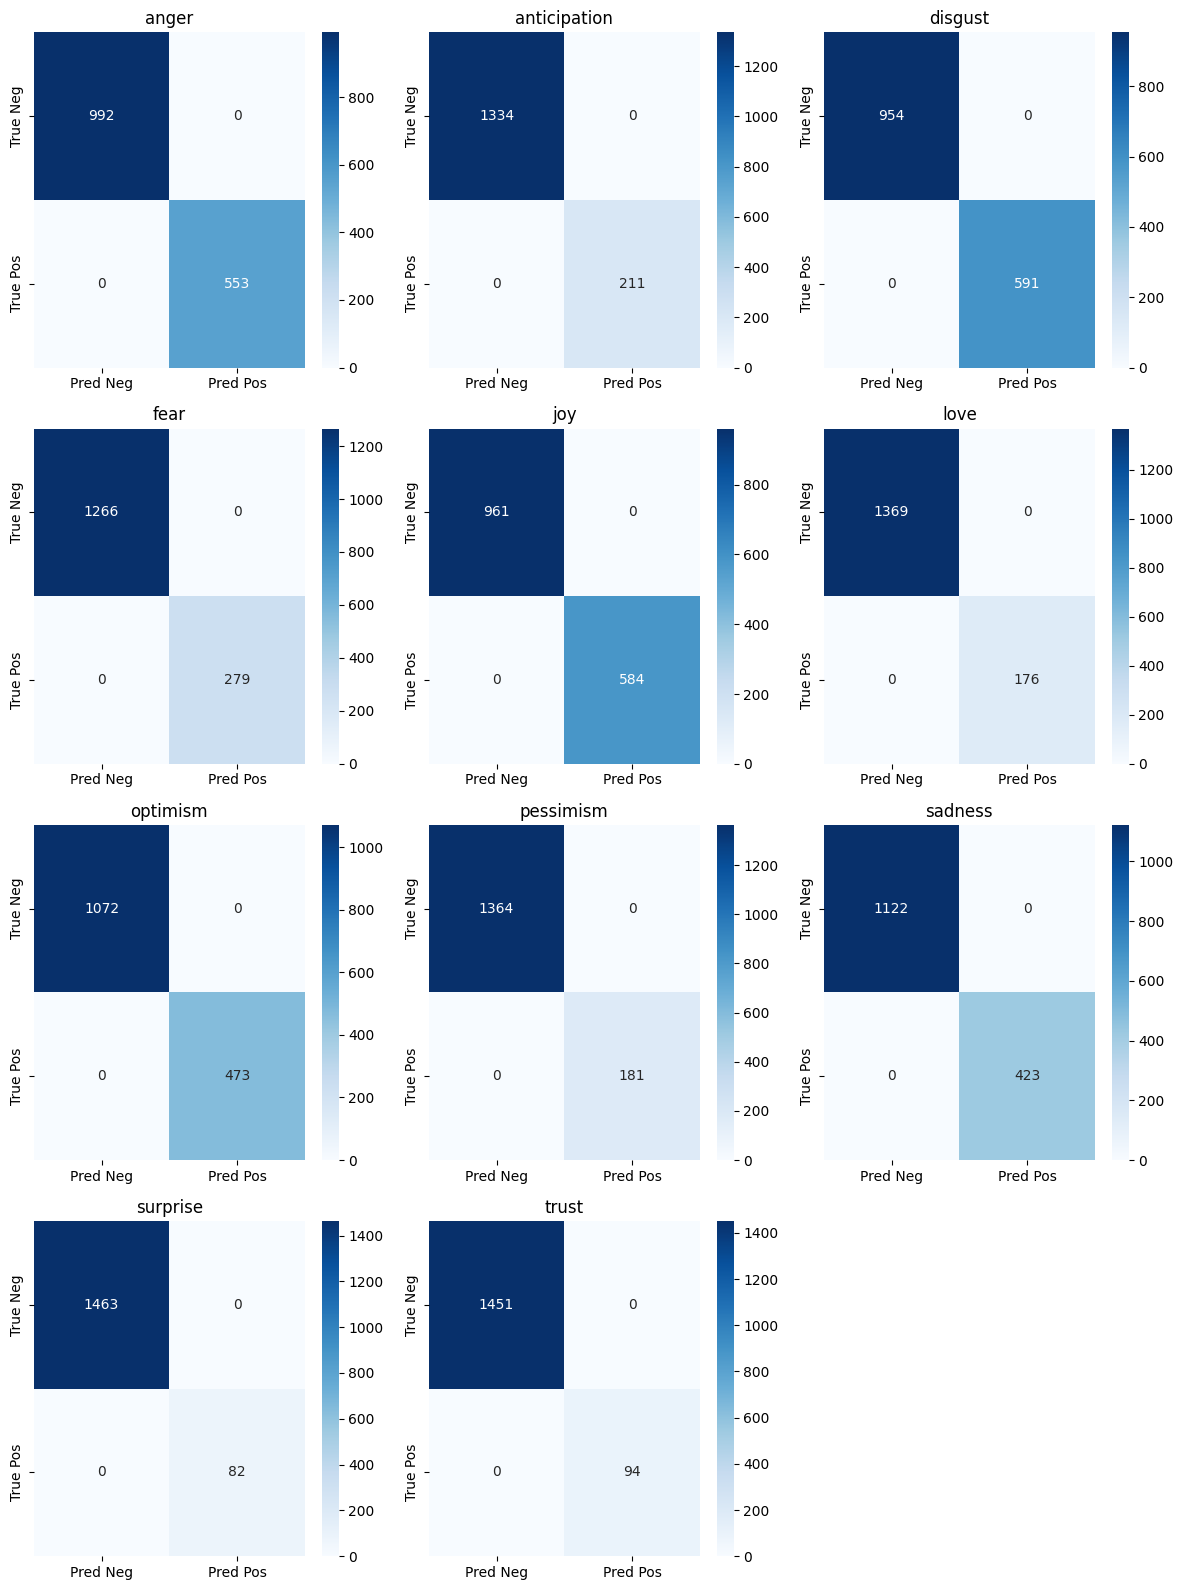

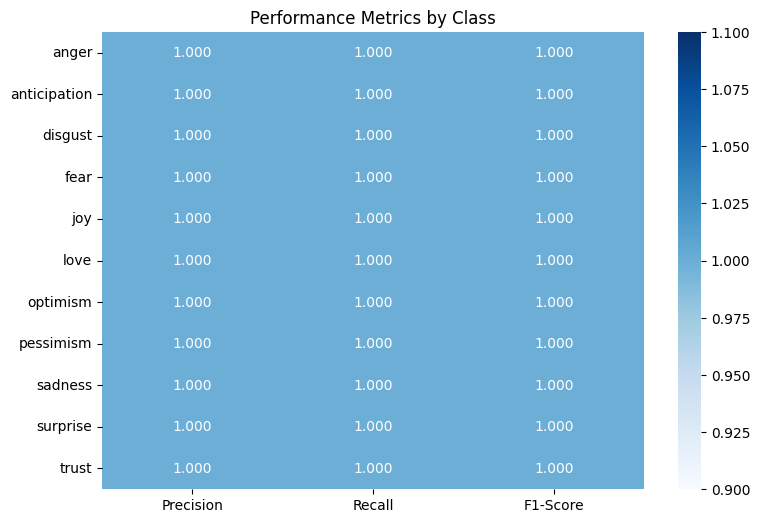

<Figure size 1200x533.333 with 0 Axes>

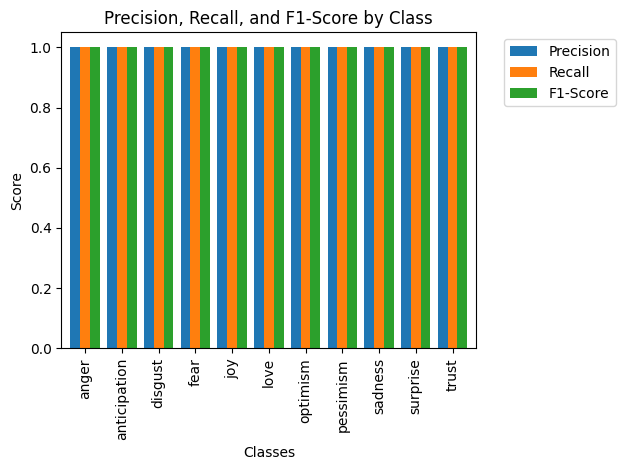

{'macro_avg': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
 'per_class': {'Precision': {'anger': 1.0,
   'anticipation': 1.0,
   'disgust': 1.0,
   'fear': 1.0,
   'joy': 1.0,
   'love': 1.0,
   'optimism': 1.0,
   'pessimism': 1.0,
   'sadness': 1.0,
   'surprise': 1.0,
   'trust': 1.0},
  'Recall': {'anger': 1.0,
   'anticipation': 1.0,
   'disgust': 1.0,
   'fear': 1.0,
   'joy': 1.0,
   'love': 1.0,
   'optimism': 1.0,
   'pessimism': 1.0,
   'sadness': 1.0,
   'surprise': 1.0,
   'trust': 1.0},
  'F1-Score': {'anger': 1.0,
   'anticipation': 1.0,
   'disgust': 1.0,
   'fear': 1.0,
   'joy': 1.0,
   'love': 1.0,
   'optimism': 1.0,
   'pessimism': 1.0,
   'sadness': 1.0,
   'surprise': 1.0,
   'trust': 1.0}}}

In [79]:
multilabel_evaluation(y_true=valid_labels_binary, y_pred=valid_predictions_binary, class_names=class_names, figsize=(12, 8))

In [80]:
model_folder = base_folder/'models/llama_qlora_lmh_inst'
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/NLP UTD/models/llama_qlora_lmh_inst/checkpoint-380'

In [81]:
free_gpu_memory()
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')
model.device
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = '<|finetune_right_pad_id|>'
tokenizer.padding_side = 'left'

GPU memory has been freed.


In [82]:
df_test = pd.read_csv(data_folder/'test.csv')

In [83]:
stack_dataset_test = Dataset.from_pandas(df_test)

In [84]:
# List of emotion columns
emotion_columns = ["anger", "anticipation", "disgust", "fear", "joy", "love",
                   "optimism", "pessimism", "sadness", "surprise", "trust"]

# Create a new column with the names of emotions where the value is 1
df_test["emotions"] = df_test[emotion_columns].apply(
    lambda row: " ".join([emotion for emotion in emotion_columns if row[emotion] == 1]), axis=1
)

# Display the DataFrame
print(df_test)

              ID                                              Tweet anger  \
0     2018-01559  @Adnan__786__ @AsYouNotWish Dont worry Indian ...  NONE   
1     2018-03739  Academy of Sciences, eschews the normally sobe...  NONE   
2     2018-00385                  I blew that opportunity -__- #mad  NONE   
3     2018-03001             This time in 2 weeks I will be 30... 😥  NONE   
4     2018-01988  #Deppression is real. Partners w/ #depressed p...  NONE   
...          ...                                                ...   ...   
3254  2018-03848  shaft abrasions from panties merely shifted to...  NONE   
3255  2018-00416  @lomadia heard of Remothered? Indie horror gam...  NONE   
3256  2018-03717        All this fake outrage. Y'all need to stop 🤣  NONE   
3257  2018-03504  Would be ever so grateful if you could record ...  NONE   
3258  2018-00115  I'm the wholesome drunk that sends people meme...  NONE   

     anticipation disgust  fear   joy  love optimism pessimism sadness  \
0

In [85]:
stack_dataset_test = Dataset.from_pandas(df_test)

In [86]:
selected_columns_test = {
    'text': stack_dataset_test['Tweet'],
    'tag': stack_dataset_test['emotions']
}

# Create a new dataset with the selected columns
stack_selected_columns_test = Dataset.from_dict(selected_columns_test)

In [87]:
stack_selected_columns_test

Dataset({
    features: ['text', 'tag'],
    num_rows: 3259
})

In [88]:
# Set the format to Pandas
stack_selected_columns_test.set_format(type='pandas')

In [89]:
df_test_1 = stack_selected_columns_test[:]

In [90]:
# Remove existing quotes first (if any) and then add just one set
import json
df_test_1['label'] = df_test_1['tag'].str.split().apply(lambda x: json.dumps([tag.strip() for tag in x]))


In [91]:
df_test

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,emotions
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
2,2018-00385,I blew that opportunity -__- #mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
3,2018-03001,This time in 2 weeks I will be 30... 😥,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,shaft abrasions from panties merely shifted to...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
3255,2018-00416,@lomadia heard of Remothered? Indie horror gam...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
3256,2018-03717,All this fake outrage. Y'all need to stop 🤣,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,
3257,2018-03504,Would be ever so grateful if you could record ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,


In [92]:
df_final_test = df_test_1[['text', 'label']]

In [93]:
stack_selected_columns_final_test = Dataset.from_pandas(df_final_test)

In [94]:
test_split = stack_selected_columns_final_test

In [95]:
test_split

Dataset({
    features: ['text', 'label'],
    num_rows: 3259
})

In [96]:
test_split = test_split.map(format_chat_inference)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [98]:
test_filtered = test_split.filter(check_length)

print(f"Train: {len(train_data)} -> {len(test_filtered)}")


Filter:   0%|          | 0/3259 [00:00<?, ? examples/s]

Train: 6179 -> 3259


In [99]:
test_filtered

Dataset({
    features: ['text', 'label'],
    num_rows: 3259
})

In [100]:
test_filtered['text'][0]

"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 14 Dec 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nClassify the TEXT by selecting all applicable labels from the following list: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'].\n\nTEXT: @Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

In [101]:
free_gpu_memory()

GPU memory has been freed.


In [102]:
test_inference_results = run_inference_instruction(seed = 42,
              dataset=test_filtered,
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=40,
              input_field='text',
              output_field='label',
              save_dir=model_folder,
              save_file_name = 'test_complete_generations')

Generating predictions: 100%|██████████| 82/82 [01:52<00:00,  1.38s/it]

Saved inference_results to: /content/drive/MyDrive/NLP UTD/models/llama_qlora_lmh_inst/test_complete_generations.json


In [103]:
file_name = model_folder/'test_complete_generations.json'
with open(file_name, 'r') as f:
    test_inference_results = json.load(f)

In [104]:
test_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in test_inference_results
]


In [105]:

# Clean and convert predictions and ground truth
test_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in test_extracted_outputs
]

test_labels = [
    clean_and_split_labels(result['ground_truth'], class_names)
    for result in test_inference_results
]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
test_labels_binary = mlb.transform(test_labels)
test_predictions_binary = mlb.transform(test_predictions)

# Print samples and shapes
print("Sample of true labels:", test_labels[:5])
print("Sample of predictions:", test_predictions[:5])
print("\nBinary format:")
print("Labels shape:", test_labels_binary.shape)
print("Predictions shape:", test_predictions_binary.shape)

Sample of true labels: [[], [], [], [], []]
Sample of predictions: [['anger', 'disgust', 'fear'], ['anger', 'disgust', 'fear', 'sadness'], ['anger', 'disgust'], ['anticipation', 'joy', 'optimism'], ['anger', 'disgust', 'fear', 'sadness']]

Binary format:
Labels shape: (3259, 11)
Predictions shape: (3259, 11)


In [106]:
test_metrics = compute_metrics(test_labels_binary , test_predictions_binary)

In [107]:
test_metrics

{'f1_micro': 0.0,
 'f1_macro': 0.0,
 'accuracy_label': 0.772406482747078,
 'accuracy_all': 0.005216324025774778}

In [108]:
wandb.log({"test_f1_macro": test_metrics["f1_macro"]})

In [109]:
wandb.finish()

eval/loss,█▇▅▄▃▃▃▂▂▂▃▂▂▂▁▁▁▁▁
eval/runtime,▅▇▆██▄█▂▄▄▅▄▅▁▄▂▂▁▂
eval/samples_per_second,▄▂▃▁▁▅▁▇▅▅▄▄▄█▅▇▇█▇
eval/steps_per_second,▄▂▃▁▁▅▁▇▅▅▄▄▄█▅▇▇█▇
test_f1_macro,▁
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
train/grad_norm,█▃▄▃▄▃▃▃▆▄▄▄▃▂▃▂▂▁▂
train/learning_rate,██▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁▁
train/loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁
valid_f1_macro,▁


In [110]:
model_folder = base_folder/'models/llama_qlora_lmh_inst'
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = '<|finetune_right_pad_id|>'
tokenizer.padding_side = 'left'

In [111]:
inference_results = run_inference_instruction(seed = 42,
              dataset=test_filtered.select(range(10)),
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=40,
              input_field='text',
              output_field='label',
)

Generating predictions: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


In [112]:
extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in inference_results
]

# Clean and convert predictions and ground truth
predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in extracted_outputs

]

In [113]:
predictions

[['anger', 'disgust', 'fear', 'sadness'],
 ['anger', 'disgust', 'sadness'],
 ['anger', 'disgust'],
 ['anticipation', 'joy', 'optimism'],
 ['fear', 'sadness'],
 ['anger', 'disgust', 'fear'],
 ['joy', 'optimism'],
 ['joy', 'love', 'optimism'],
 ['joy', 'love', 'optimism'],
 ['sadness']]

In [114]:
# Create a DataFrame with the predictions
predictions_df = pd.DataFrame(test_predictions_binary, columns=class_names)

In [115]:
# Add the 'ID' column from the test set
predictions_df.insert(0, 'ID', df_test['ID'])

In [116]:
# Ensure the columns are in the correct order
column_order = ['ID'] + class_names
predictions_df = predictions_df[column_order]
result_df = predictions_df

In [117]:
result_df.to_csv(data_folder/'govardhan8th_part2.csv', index=False)